In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.observable import *

sys.modules['oom'] = oom

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [ ]:
n_obs = 4
src_dim = 8
learnlen = 70000
testlen = 30000

random_oom = DiscreteValuedOOM.from_sparse(
    src_dim,
    density = 0.3,
    alphabet_size = n_obs,
    deterministic_functional = False
)
# print("\nGenerated OOM\n", random_oom)
_, nlls_ground, seq, ps_ground = random_oom.generate(length = learnlen + testlen)
_, nlls_ground_test, ps_ground_test = random_oom.compute(seq[learnlen:])
# del random_oom

dim_search = [4, 5, 6, 7, 8, 9, 10, 11, 12]
max_length = int(max(np.log2(dim_search)))

nlls_err_learned = []

for idx, target_dim in enumerate(dim_search):
    learned_oom = DiscreteValuedOOM.from_data(
        seq,
        target_dim,
        max_length = max_length
    )
    
    # Save difference in nll from ground (min) to learned
    _, nlls_learned_test, ps_learned_test = learned_oom.compute(seq[learnlen:])
    nlls_err_learned.append(nlls_learned_test[-1])
    
    # del learned_oom
    # del nlls_learned_test

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
xlims = [min(dim_search), max(dim_search)]

fig = plt.figure()
ax = plt.gca()

# Entropy estimates of learned OOMs on test sequence (by dimension)
ax.plot(dim_search, nlls_err_learned,
         marker='o', markersize=3,
         label = r"$\hat{H}(P_d \Vert P_\text{true})$")

# Entropy of uniform process
ax.hlines(y = np.log2(n_obs), xmin=xlims[0], xmax=xlims[1],
           color='r', ls=(1, (5, 3)), linewidth=2, alpha=0.6,
           label = r"$\hat{H}(P_\text{uniform})$")

# Entropy estimates of ground OOM on test sequence
ax.hlines(y = nlls_ground[-1], xmin=xlims[0], xmax=xlims[1],
           color='g', ls=(0, (4, 3)), linewidth=2, alpha=0.6,
           label = r"$\hat{H}(P_\text{true}$)")

ax.set_xscale('log', base=2)
ax.set_xticks(dim_search)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlim(xlims)
ax.set_xlabel("Learned OOM dimension ($d$)")

ax.set_ylabel("Entropy estimates ($\\text{NLL} \\approx \\hat{H}$)")

ax.legend(loc="center right", title=f"True OOM $d = {src_dim}, \\vert\\Sigma\\vert = {n_obs}$")
ax.grid(True, alpha=0.5)

fig.set_layout_engine("constrained")

plt.show()

In [ ]:
plt.figure()
ax = plt.gca()

# ax.set_xscale('log', base=2)
# ax.set_xticks(dim_search)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xlim(xlims)

ax.plot(nlls_ground_test, label="ground")
ax.plot(nlls_learned_test, label="learned")
ax.legend()

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (5, 3))
axs = axs.flatten()

from IPython import display
hdisplay = display.display("", display_id=True)

ooms = [random_oom, learned_oom]
state = [states_ground, states_learned]

for stateidx in range(len(state[0])):
    for idx, ax in enumerate(axs):
        ax.clear()
        
        weights = np.array(ooms[idx].lf_on_operators * state[idx][stateidx]).flatten()
        values = np.arange(0, weights.shape[0] + 1)
        
        _, bins, _ = ax.hist(
            x = values[:-1],
            weights = weights,
            bins = values,
            align='mid',
            histtype='bar',
            edgecolor='k',
            facecolor='lightblue'
        )
        
        ax.axhline(
            np.mean(weights),
            color='r',
            ls='--'
        )
        
        ax.set_xticks(values)
        ax.set_xlim([min(values), max(values)])
        ax.set_ylim([min(-5, 1.2*min(weights)), max(5, 1.2*max(weights))])
    
    fig.set_layout_engine('constrained')
    # plt.show()
    hdisplay.update(fig)

In [ ]:


ooms = [random_oom, learned_oom]
# state = [states_ground, states_learned]
state = [states_ground, learned_oom.generate(length=testlen)[0]]

oomidx = 1

n_obs = len(ooms[oomidx].observables)
plts = [[] for _ in range(n_obs)]

for stateidx in range(len(state[oomidx])):
    weights = np.array(ooms[oomidx].lf_on_operators * state[oomidx][stateidx]).flatten()
    print(weights)

    for obsidx, item in enumerate(weights):
        plts[obsidx].append(item)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

for obsidx in range(n_obs):
    plt.plot(running_mean(plts[obsidx], 5000))

plt.show()

In [ ]:
state = learned_oom.start_state
for idx in range(50):
    opidx = np.random.randint(low=0, high=len(learned_oom.operators))
    state = learned_oom.operators[opidx](state)
    print(learned_oom.obsnames[opidx], np.array(learned_oom.lf_on_operators * state).flatten())

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

ps_hor = [[] for _ in range(len(ps_learned))]
ps_sums = []
for entry in ps_learned:
    for idx, val in enumerate(entry):
        ps_hor[idx].append(val)
    ps_sums.append(np.sum(entry))

In [ ]:
for idx, pvals in enumerate(ps_hor):
    plt.plot(running_mean(pvals, 10))
plt.plot(ps_sums)

# Newest

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.observable import *

sys.modules['oom'] = oom

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from src.main import experiment_dimension

In [27]:
n_obs = 10
src_dim = 2
trainlen = 70000
testlen = 30000
dim_search = [2, 4, 6, 8]
maxlen_ciw = 4
sparsity = 0.01
repetitions = 2

results = experiment_dimension(
    n_obs = n_obs,
    src_dim = src_dim,
    trainlen = trainlen,
    testlen = testlen,
    dim_search = dim_search,
    maxlen_ciw = maxlen_ciw,
    sparsity = sparsity,
    repetitions = repetitions
)

    repetition = 0
    target_dimension = 2 4 6 8 | Done
    repetition = 1
    target_dimension = 2 4 6 8 | Done


In [28]:
seq = results[0]
# vvv organized as (states, NLLs, probability vectors)
ground_train = results[1]
ground_test = results[2]
learned_test = results[3]

nll_test_mean = results[4]
nll_test_var = results[5]
nll_test_all = results[6]
nll_test_all

,0,1,sparsity
2,3.171947,3.171146,0.01
4,3.180397,3.177994,0.01
6,4.473049,3.656886,0.01
8,3.676618,4.187642,0.01


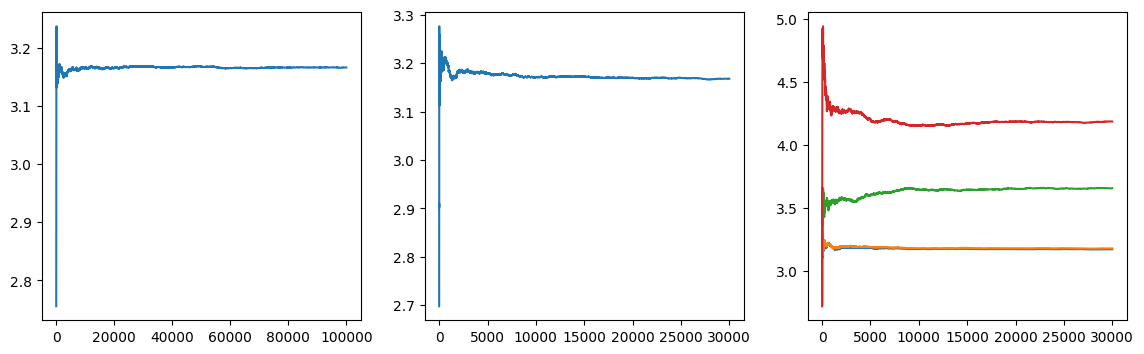

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (14, 4))
axs = axs.flatten()

axs[0].plot(ground_train[1])
axs[1].plot(ground_test[1])
for dim in learned_test[1]:
    axs[2].plot(learned_test[1][dim])

(0.0, 30000.0)

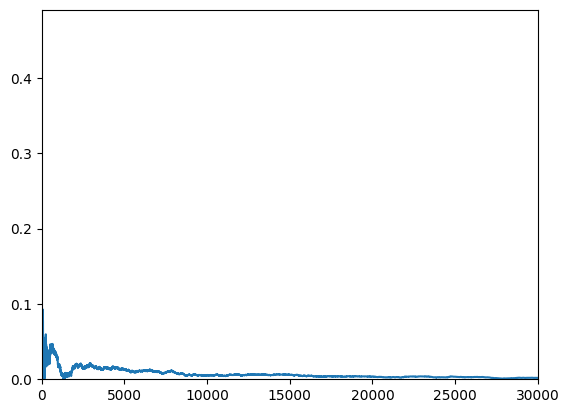

In [30]:
tmax = testlen

diff = np.array(ground_train[1][trainlen:]) - np.array(ground_test[1])
plt.plot(
    np.sqrt(diff ** 2)[:tmax]
)
plt.ylim([0, 1.05*max(diff)])
plt.xlim([0, tmax])

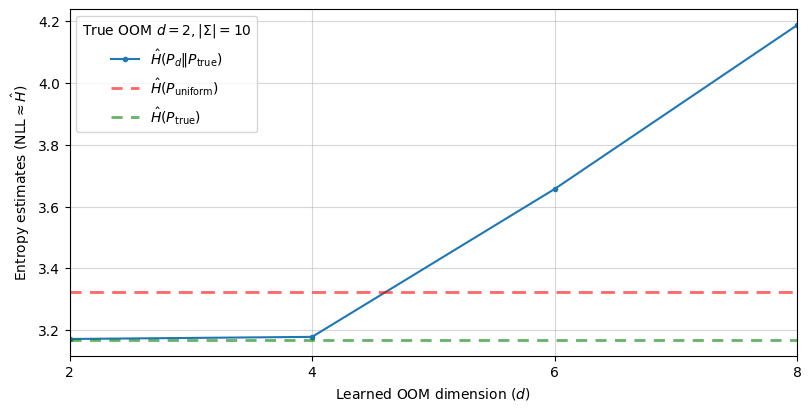

In [31]:
# Get uniform process entropy
entropy_uniform = np.log2(n_obs)

ds = pd.Series(learned_test[1]).apply(lambda x: x[-1])
# ds = ds[ds <= entropy_uniform]
# df['var'] = 0.01

# Get x-axis limits
xlims = [ds.index.min(), ds.index.max()]

# Create figure
fig = plt.figure(figsize = (8, 4))
ax = plt.gca()

# Plot (cross-)entropy estimates of learned OOMs by dimension (mean +- std)
ax.plot(
    ds,
    marker='o', markersize=3,
    label = r"$\hat{H}(P_d \Vert P_\text{true})$"
)

# Entropy of uniform process
ax.hlines(
    y = entropy_uniform,
    xmin = xlims[0],
    xmax = xlims[1],
    color = 'r',
    ls = (1, (5, 3)),
    linewidth = 2,
    alpha = 0.6,
    label = r"$\hat{H}(P_\text{uniform})$"
)

# Entropy estimates of ground OOM on test sequence
ax.hlines(
    y = ground_test[1][-1],
    xmin = xlims[0],
    xmax = xlims[1],
    color = 'g',
    ls = (0, (4, 3)),
    linewidth = 2,
    alpha = 0.6,
    label = r"$\hat{H}(P_\text{true}$)"
)

# ax.set_xscale('log', base=2)
ax.set_xticks(dim_search)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlim(xlims)
ax.set_xlabel("Learned OOM dimension ($d$)")

ax.set_ylabel("Entropy estimates ($\\text{NLL} \\approx \\hat{H}$)")

ax.legend(title=f"True OOM $d = {src_dim}, \\vert\\Sigma\\vert = {n_obs}$")
ax.grid(True, alpha=0.5)

fig.set_layout_engine("constrained")

plt.show()

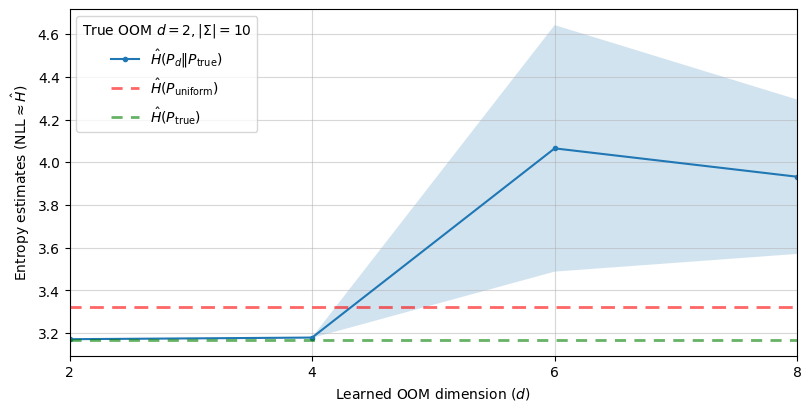

In [32]:
# Get uniform process entropy
entropy_uniform = np.log2(n_obs)

df = pd.concat([nll_test_mean, nll_test_var], axis = 1)
df.columns = ['mean', 'var']
# df = df[df['mean'] <= entropy_uniform]
# df['var'] = 0.01

# Get x-axis limits
xlims = [df.index.min(), df.index.max()]

# Create figure
fig = plt.figure(figsize = (8, 4))
ax = plt.gca()

# Plot (cross-)entropy estimates of learned OOMs by dimension (mean +- std)
ax.fill_between(
    x = df.index,
    y1 = df['mean'] - df['var'],
    y2 = df['mean'] + df['var'],
    alpha = 0.2
)
ax.plot(
    df['mean'],
    marker='o', markersize=3,
    label = r"$\hat{H}(P_d \Vert P_\text{true})$"
)

# Entropy of uniform process
ax.hlines(
    y = entropy_uniform,
    xmin = xlims[0],
    xmax = xlims[1],
    color = 'r',
    ls = (1, (5, 3)),
    linewidth = 2,
    alpha = 0.6,
    label = r"$\hat{H}(P_\text{uniform})$"
)

# Entropy estimates of ground OOM on test sequence
ax.hlines(
    y = ground_test[1][-1],
    xmin = xlims[0],
    xmax = xlims[1],
    color = 'g',
    ls = (0, (4, 3)),
    linewidth = 2,
    alpha = 0.6,
    label = r"$\hat{H}(P_\text{true}$)"
)

# ax.set_xscale('log', base=2)
ax.set_xticks(dim_search)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlim(xlims)
ax.set_xlabel("Learned OOM dimension ($d$)")

ax.set_ylabel("Entropy estimates ($\\text{NLL} \\approx \\hat{H}$)")

ax.legend(title=f"True OOM $d = {src_dim}, \\vert\\Sigma\\vert = {n_obs}$")
ax.grid(True, alpha=0.5)

fig.set_layout_engine("constrained")

plt.show()

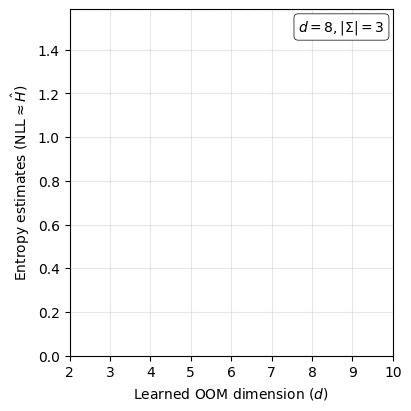

n_obs = 3, src_dim = 8, sparsity = 0.3
C1: creation, C2: generation, C3: computation, C4: matrices
    repetition = 0 | target dimension = 2 3 4 5 6 7 8 9 10 | Done
C1: creation, C2: generation, C3: computation, C4: matrices
    repetition = 1 | target dimension = 2 3 4 5 6 7 8 9 10 | Done
C1: creation, C2: generation, C3: computation, C4: matrices
    repetition = 2 | target dimension = 2 3 4 5 6 7 8 9 10 | Done
C1: creation, C2: generation, C3: computation, C4: matrices
    repetition = 3 | target dimension = 2 3 4 5 6 7 8      BEFORE
    Time step 1134
    State [[ -26.36463198  -19.83435362   -4.61664062   -5.91652549  189.16842077
    65.87263399   38.32892072 -134.33220446]]
    p_vec: [-1155.52858398   457.16505642   699.36352756]
[0.77675278 0.21824722 0.005     ]
[0.1611264 0.8338736 0.005    ]
[0.24851168 0.46883281 0.28265551]
[0.26480924 0.2604306  0.47476016]
[8.51003453e-01 1.48318307e-01 6.78239639e-04]
    AFTER
[0.005      0.12473028 0.87026972]
[0.82943773 0.16556227 

KeyboardInterrupt: 

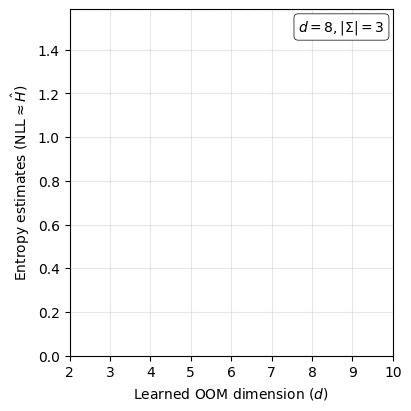

In [43]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.observable import *
from src.main import experiment_dimension

sys.modules['oom'] = oom

import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython import display
hdisplay = display.display("", display_id=True)


########################################################

n_obs_l = [3]
src_dim_l = [8]
trainlen = 100000
testlen = 50000
dim_search = range(2, 10 + 1)
maxlen_ciw = 4
sparsity_l = [0.3]
repetitions = 10

# meta-x-axis: n_obs
# meta-y-axis: src_dim
nrows = len(src_dim_l)
ncols = len(n_obs_l)
fig, axs = plt.subplots(ncols, nrows, figsize = (4 * nrows, 4 * ncols))
fig.set_layout_engine("constrained")
try:
    axs = axs.flatten()
except AttributeError:
    axs = [axs]

cmap = mpl.colormaps['cividis']
hues = np.linspace(0, 0.75, len(sparsity_l))
sparsity_l_colors = [mpl.colors.hsv_to_rgb((hue, 1.0, 0.8)) for hue in hues]


########################################################


subplotidx = 0
for n_obs, src_dim in itertools.product(
    n_obs_l, src_dim_l
):
    entropy_uniform = np.log2(n_obs)
    
    # Ax setup
    ax = axs[subplotidx]
    
    # Ax - axes ticks
    ax.set_xticks(dim_search)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    # Ax - axes limits
    xlims = [min(dim_search), max(dim_search)]
    ax.set_xlim(xlims)
    curr = ax.get_ylim()
    ymax = entropy_uniform
    ax.set_ylim([curr[0], ymax])
    
    # Ax - axis labels
    if nrows * (ncols - 1) - 1 < subplotidx < nrows * ncols:
        ax.set_xlabel("Learned OOM dimension ($d$)")
    if subplotidx % nrows == 0:
        ax.set_ylabel("Entropy estimates ($\\text{NLL} \\approx \\hat{H}$)")

    # Ax - legend and grid
    ax.annotate(
        text = f"$d = {src_dim}, \\vert\\Sigma\\vert = {n_obs}$",
        xy = (0.975, 0.975),
        xycoords = 'axes fraction',
        horizontalalignment = 'right',
        verticalalignment = 'top',
        bbox = dict(
            boxstyle = 'round',
            facecolor = 'w',
            linewidth = 0.5,
            edgecolor = 'k',
        )
    )
    ax.grid(True, alpha = 0.3, zorder = -1)
    
    # Entropy of uniform process
    ax.hlines(
        y = entropy_uniform,
        xmin = xlims[0],
        xmax = xlims[1],
        color = 'r',
        ls = (1, (5, 3)),
        linewidth = 1.5,
        alpha = 0.6,
        # label = r"$\hat{H}(P_\text{uniform})$"
    )
    
    subplotidx += 1
hdisplay.update(fig)


########################################################


subplotidx = 0
for n_obs, src_dim in itertools.product(
    n_obs_l, src_dim_l
):
    ax = axs[subplotidx]
    
    for sparsity, col in zip(sparsity_l, sparsity_l_colors):
        print(f"n_obs = {n_obs}, src_dim = {src_dim}, sparsity = {sparsity}")

        results = experiment_dimension(
            n_obs = n_obs,
            src_dim = src_dim,
            trainlen = trainlen,
            testlen = testlen,
            dim_search = dim_search,
            maxlen_ciw = maxlen_ciw,
            sparsity = sparsity,
            repetitions = repetitions
        )

        seq = results[0]
        # vvv organized as _TraversalStates
        ground_train = results[1]
        ground_test = results[2]
        learned_test = results[3]

        nll_test_mean = results[4]
        nll_test_var = results[5]
        nll_test_all = results[6]

        df = nll_test_all
        df['mean'] = df.drop(['sparsity'], axis = 1).mean(axis = 1)
        df['var'] = df.drop(['sparsity'], axis = 1).var(axis = 1)
        print(df)

        # Plot (cross-)entropy estimates of learned OOMs by dimension (mean +- std)
        ax.fill_between(
            x = df.index,
            y1 = df['mean'] - df['var'],
            y2 = df['mean'] + df['var'],
            color = col,
            alpha = 0.1,
        )
        ax.plot(
            df['mean'],
            color = col,
            marker = 'o',
            markersize = 3,
            # label = r"$\hat{H}(P_d \Vert P_\text{true})$"
        )

        # Entropy estimates of ground OOM on test sequence
        ax.hlines(
            y = ground_test.nll_list[-1],
            xmin = xlims[0],
            xmax = xlims[1],
            color = col,
            alpha = 0.6,
            ls = (0, (4, 3)),
            linewidth = 2,
            # label = r"$\hat{H}(P_\text{true}$)"
        )

        # Ax - y-axis lower limit
        curr = ax.get_ylim()
        if sparsity_l.index(sparsity) == 0:
            print("-------------------------Changing things")
            ymin = ground_test[1][-1]
            ymax = entropy_uniform
        else:
            ymin = min(curr[0], ground_test.nll_list[-1])
            ymax = max(curr[1], entropy_uniform)
        yminf = ymin - 0.05 * (ymax - ymin)
        ymaxf = ymax + 0.05 * (ymax - ymin)
        print(yminf, ymaxf)
        ax.set_ylim([yminf, ymaxf])

        hdisplay.update(fig)
    subplotidx += 1

hdisplay.update(fig)

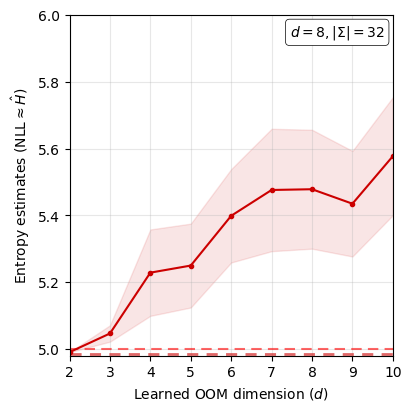

In [9]:
managed_fig = plt.figure()
canvas_manager = managed_fig.canvas.manager
canvas_manager.canvas.figure = fig
axs = fig.axes
axs[0].set_ylim([4.98, 6])
fig.set_canvas(canvas_manager.canvas)

NameError: name 'df' is not defined

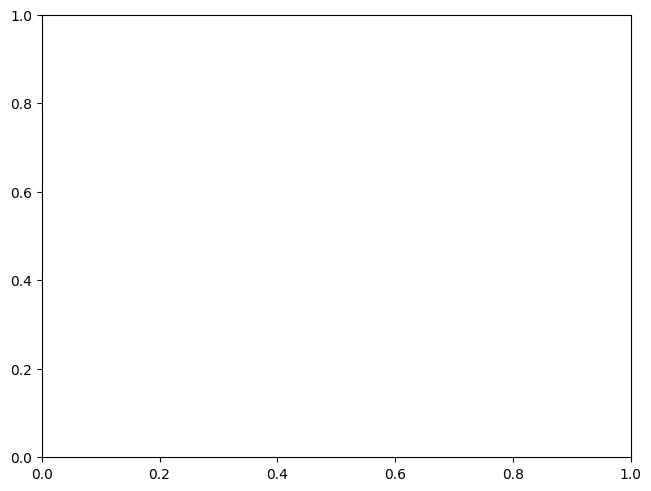

In [44]:
fig, axs = plt.subplots()
fig.set_layout_engine("constrained")
try:
    axs = axs.flatten()
except AttributeError:
    axs = [axs]

ax = axs[0]

mapmax = 0.5
cmap = mpl.colormaps['viridis']
cols = cmap(np.linspace(0, mapmax, len(df.columns) - 3))
cols = [col for col in cols]

for col in df.columns:
    if col in ['sparsity', 'mean', 'var']:
        continue
    ax.plot(
        df[col],
        color = cols[col],
        ls = (1, (3, 2)),
        linewidth = 1,
    )
#

# Entropy of uniform process
ax.hlines(
    y = entropy_uniform,
    xmin = xlims[0],
    xmax = xlims[1],
    color = 'r',
    ls = (1, (5, 3)),
    linewidth = 1.5,
    alpha = 0.6,
    # label = r"$\hat{H}(P_\text{uniform})$"
)

# Entropy estimates of ground OOM on test sequence
ax.hlines(
    y = ground_test[1][-1],
    xmin = xlims[0],
    xmax = xlims[1],
    color = 'k',
    alpha = 0.6,
    ls = (0, (4, 3)),
    linewidth = 2,
    # label = r"$\hat{H}(P_\text{true}$)"
)

# Ax - legend and grid
ax.annotate(
    text = f"$d = {src_dim}, \\vert\\Sigma\\vert = {n_obs}$",
    xy = (0.975, 0.975),
    xycoords = 'axes fraction',
    horizontalalignment = 'right',
    verticalalignment = 'top',
    bbox = dict(
        boxstyle = 'round',
        facecolor = 'w',
        linewidth = 0.5,
        edgecolor = 'k',
    )
)
ax.grid(True, alpha = 0.3, zorder = -1)

# Ax - axes ticks
ax.set_xticks(dim_search)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# Ax - axes limits
xlims = [min(dim_search), max(dim_search)]
ax.set_xlim(xlims)

# # Ax - y-axis lower limit
# curr = ax.get_ylim()
# ymin = ground_test[1][-1]
# ymax = entropy_uniform
# yminf = ymin - 0.05 * (ymax - ymin)
# ymaxf = ymax + 0.05 * (ymax - ymin)
# print(yminf, ymaxf)
# ax.set_ylim([2.65, 3.65])

norm = mpl.colors.Normalize(vmin=0, vmax=repetitions)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax)

plt.show()

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.observable import *
from src.main import experiment_dimension

sys.modules['oom'] = oom

import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython import display
# hdisplay = display.display("", display_id=True)


 0.9999999999999999 
 1.0
    -1.110223024625157e-16 145503
    -2.220446049250313e-16 155180
    +2.220446049250313e-16 140712
    -3.330669073875470e-16 31940
    +4.440892098500626e-16 49581
    +6.661338147750939e-16 1252
    -4.440892098500626e-16 18781
    -5.551115123125783e-16 2088
    -6.661338147750939e-16 865
    -9.992007221626409e-16 1
    -7.771561172376096e-16 71
    +8.881784197001252e-16 175
    -8.881784197001252e-16 21
    +1.110223024625157e-15 1


<Axes: >

C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 132 (\x84) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 133 (\x85) missing from font(s) DejaVu Sans.
  fun

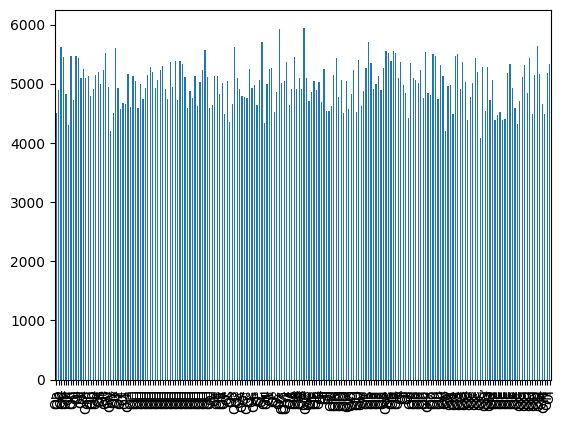

In [8]:
from collections import Counter

alphabet_size = 200
dimension = 200
sparsity = 0.3
myoom = DiscreteValuedOOM.from_sparse(alphabet_size=alphabet_size, dimension=dimension, density=1/alphabet_size,
                                      deterministic_functional=False, stationary_state=True,
                                      seed=None)
print('\n', (myoom.lin_func * myoom.start_state)[0, 0], '\n', np.sum(myoom.lf_on_operators * myoom.start_state))
# for op in myoom.operators:
#     print("    " + op.observable.uid + " operator sums:")
#     print("    col:", np.sum(op.mat, axis = 0).flatten())
#     print("    row:", np.sum(op.mat, axis = 1).flatten())
# print(myoom)
# print("functional on operators:\n", myoom.lf_on_operators, sep='')

generation = myoom.generate(1000000)
seq = generation[2]
counts = sorted(Counter(seq).items(), key = lambda pair: pair[0], reverse = False)
pd.Series([pair[1] for pair in counts], index = [pair[0] for pair in counts]).plot(kind = 'bar')

In [11]:
import scipy as sp
from scipy.stats import beta, uniform, norm

In [17]:
x = np.linspace(0, 1, 1000)

1
4 8.0
2
4 2.0


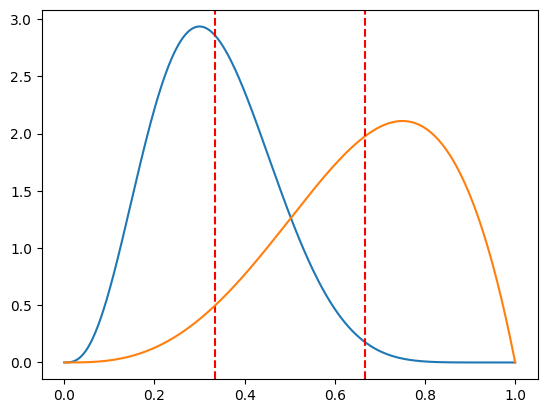

In [61]:
N = 2
x_vlines = np.linspace(0, 1, (N + 1) + 1, endpoint = True)[1 : -1]

a = 4

for idx, xv in zip(range(1, N + 1), x_vlines):
    print(idx)
    offset = a * (N + 1 - 2 * idx) / idx
    b = a + offset
    print(a, b)
    
    pdf1 = beta(a = a, b = b, loc = 0, scale = 1)
    plt.plot(x, pdf1.pdf(x))
    
    plt.axvline(xv, color = 'r', ls = '--')

1
8 23.333333333333336
2
8 8.0
3
8 2.8888888888888884


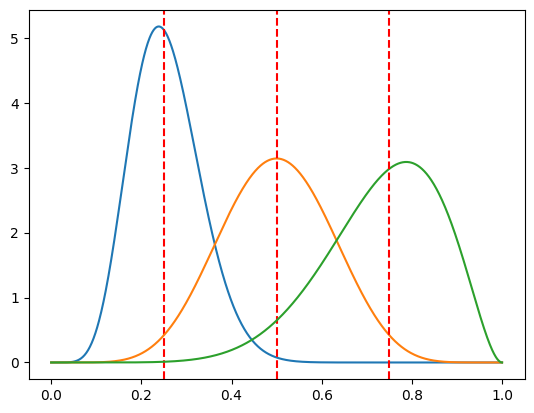

In [60]:
N = 3
x_vlines = np.linspace(0, 1, (N + 1) + 1, endpoint = True)[1 : -1]

a = 8

for idx, xv in zip(range(1, N + 1), x_vlines):
    print(idx)
    offset = (a - 1/3) * (N + 1 - 2 * idx) / idx
    b = a + offset
    print(a, b)
    
    pdf1 = beta(a = a, b = b, loc = 0, scale = 1)
    plt.plot(x, pdf1.pdf(x))
    
    plt.axvline(xv, color = 'r', ls = '--')

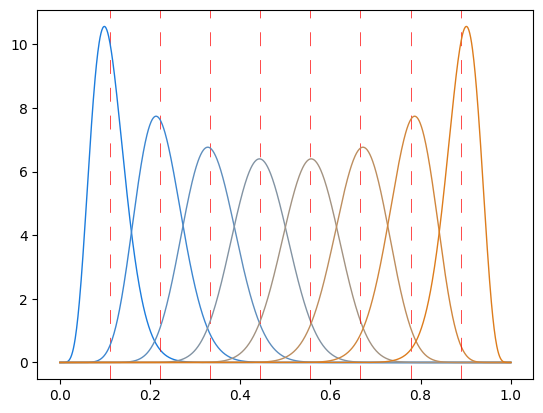

In [113]:
N = 8
x_vlines = np.linspace(0, 1, (N + 1) + 1, endpoint = True)[1 : -1]

total = 64

for idx, xv in zip(range(1, N + 1), x_vlines):
    plt.axvline(xv, color = 'r', linewidth = 0.5, linestyle = (0, (20, 20)))
    
    # print(idx)
    offset = total / 2 * (N + 1 - 2*idx) / (N + 1)
    athis = total / 2 - offset
    bthis = total / 2 + offset
    # print(f"{offset=}, {athis=}, {bthis=}, {total=}")
    
    pdf1 = beta(a = athis, b = bthis, loc = 0, scale = 1)
    
    color = np.array([athis, total / 2, bthis])
    color = color / np.linalg.norm(color)
    plt.plot(x, pdf1.pdf(x), linewidth = 1, color = color)

In [248]:
alphabet_size = 5
pvec = np.random.rand(alphabet_size)
pvec = pvec / np.sum(pvec)
pvec

array([0.31109082, 0.23678742, 0.10698175, 0.31267312, 0.03246688])

In [287]:
pveccum = np.concatenate([[0], np.cumsum(pvec)[:-1]])
rvs = uniform(loc = 0, scale = 1).rvs

cutoff = rvs()
cutoffs = np.cumsum(pvec) < cutoff
print(pveccum)
print(cutoff)
print(cutoffs)

# conv = np.convolve(cutoffs, [0.5, 0.5], "valid")
# print(conv)
cutoffidx = np.argmin(cutoffs)
print(cutoffidx, '-', cutoffidx+1)

# All in one
cutoff = rvs()
cutoffidx = np.argmin(np.cumsum(pvec) < cutoff)
print(cutoffidx, '-', cutoffidx+1)

[0.         0.09482513 0.25864049 0.38173996 0.85925481]
0.19290884495247607
[ True False False False False]
1 - 2
0 - 1


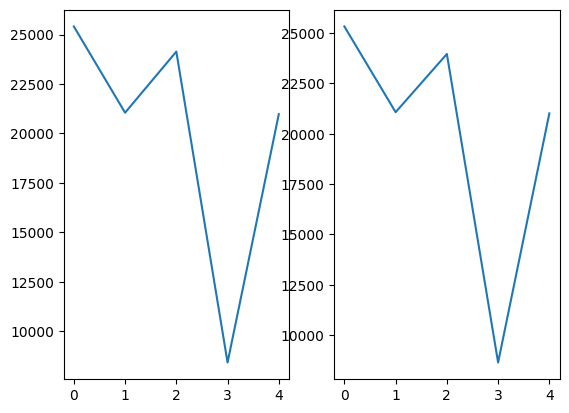

In [342]:
alphabet_size = 5
pvec = np.random.rand(alphabet_size)
pvec = pvec / np.sum(pvec)

counts = dict.fromkeys(range(alphabet_size), 0)
counts2 = dict.fromkeys(range(alphabet_size), 0)

for _ in range(100000):
    cutoff = rvs()
    cutoffidx = np.argmin(np.cumsum(pvec) < cutoff)
    counts[cutoffidx] += 1
    
    cutoffidx2 = np.random.choice([i for i in range(alphabet_size)], p = pvec)
    counts2[cutoffidx2] += 1

fig, axs = plt.subplots(1, 2)
axs = axs.flatten()

axs[0].plot(counts.values())
axs[1].plot(counts2.values())

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.observable import *
from src.main import experiment_dimension

sys.modules['oom'] = oom

import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython import display
# hdisplay = display.display("", display_id=True)

In [1]:
from collections import Counter

alphabet_size = 10
dimension = 5
sparsity = 0.7
# print('\n', (myoom.lin_func * myoom.start_state)[0, 0], '\n', np.sum(myoom.lf_on_operators * myoom.start_state))

learnlen = 300000
testlen = 100000

repetitions = 25
errc = 0

for rep in range(repetitions):
    try:
        myoom = DiscreteValuedOOM.from_sparse(alphabet_size=alphabet_size, dimension=dimension, density=1-sparsity,
                                      deterministic_functional=False, stationary_state=False,
                                      seed=None)
        
        generation = myoom.generate(learnlen + testlen)
        seq = generation.sequence[:learnlen]
        # counts = sorted(Counter(seq).items(), key = lambda pair: pair[0].uid, reverse = False)
        # pd.Series([pair[1] for pair in counts], index = [pair[0] for pair in counts]).plot(kind = 'bar')

        loom = DiscreteValuedOOM.from_data(
            obs = seq,
            target_dimension = 10,
            max_length = 2
        )
        computation = loom.compute(generation.sequence[learnlen:])
    except TimeoutError:
        errc += 1
        print(f"\n{errc=}, {errc/(rep+1)}%")
errc

NameError: name 'DiscreteValuedOOM' is not defined

In [ ]:
100 * errc / repetitions

In [18]:
comp = myoom.compute(generation.sequence[learnlen:])
computation = loom.compute(generation.sequence[learnlen:])

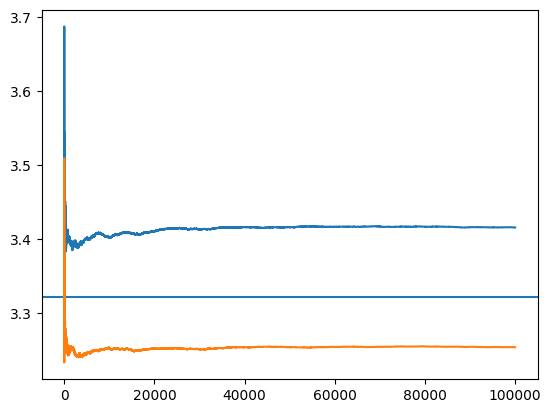

In [19]:
plt.axhline(y = np.log2(alphabet_size))
# plt.plot(generation.nll_list)
plt.plot(comp.nll_list)
plt.plot(computation.nll_list)

In [23]:
alphabet_size = 5
dimension = 50
sparsity = 0.9
learnlen = 300000
testlen = 100000

myoom = DiscreteValuedOOM.from_sparse(
    alphabet_size=alphabet_size, dimension=dimension, density=1-sparsity,
    deterministic_functional=False, stationary_state=False, seed=None
)

generation = myoom.generate(learnlen + testlen)
seq = generation.sequence[:learnlen]

In [28]:
loom = DiscreteValuedOOM.from_data(
    obs = seq,
    target_dimension = 7,
    max_length = 4
)

7 [0.14077531 0.08032192 0.01437421 0.00508198 0.00393958 0.00384382
 0.00328626]


In [29]:
computation = loom.compute(seq)

ValueError: probability explosion, observations distributed in a vector with norm 2.71781967792928. Is your model dimension much larger than the process it models? (current OOM dimension = 7)

In [15]:
length_max = None

sequence = generation.sequence[learnlen:]

stop = min(len(sequence), length_max) if length_max else len(sequence)
mode = loom._TraversalMode.COMPUTE
loom.tv = loom.get_traversal_state(stop, mode)
loom.tv.sequence = sequence

pn1counts = {}

nll: float = 0

while loom.tv.time_step < loom.tv.time_stop:
    state = loom.tv.state_list[-1]
    p_vec, adjustflag = loom.step_get_distribution(state)
    if adjustflag:
        continue

    loom.tv.time_step += 1

    loom.tv.p_vecs.append(p_vec)

    ###### DEBUG
    if abs(np.sum(p_vec) - 1) > 1e-13:
        print(f"---------------IA NEEDED 2--------------{np.sum(p_vec)}")
    if np.sum(p_vec) - 1 != 0:
        if np.sum(p_vec) - 1 not in pn1counts:
            pn1counts[np.sum(p_vec) - 1] = 0
        pn1counts[np.sum(p_vec) - 1] += 1

    # Adding
    match loom.tv.mode:
        case loom._TraversalMode.COMPUTE:
            op = loom._compute_step()
        case loom._TraversalMode.GENERATE:
            # try:
            op = loom._generate_step()
            # except ValueError as err: # TODO: remove try-catch
            # 	if err.args[0] == "probabilities do not sum to 1":
            # 		for p, ct in pn1counts.items():
            # 			print(f"    {'+' if p > 0 else ''}{p : <.15e} {ct}")
            # 		print(loom.tv.time_step)
            # 		start = max(0, loom.tv.time_step-10)
            # 		for ts, state, pvi in zip(
            # 			range(start, loom.tv.time_step + 1),
            # 			loom.tv.statelist[start:],
            # 			loom.tv.pvecs[start:]
            # 		):
            # 			print(ts, ':', np.sum(pvi), state.flatten())
            # 			print('    ', list(pvi.flatten()))
            # 		print(loom.tv.sequence[-10:])
            # 		raise
        case _:
            raise NotImplementedError("Can only compute or generate.")

    # Apply operator to get next state
    state = op(state)
    state = state / (loom.lin_func * state)
    loom.tv.state_list.append(state)

    idxoi = loom.observables.index(op.observable) # TODO not ok for cont

    # Get NLL using current observation
    nll = nll - (nll + np.log2(p_vec[idxoi])) / loom.tv.time_step
    loom.tv.nll_list.append(nll)

KeyboardInterrupt: 

In [89]:
while loom.tv.time_step < loom.tv.time_stop:
    state = loom.tv.state_list[-1]
    print(loom.tv.sequence[loom.tv.time_step - 1])
    pprint(state.T)
    print("state norm:", np.linalg.norm(state))
    print("lf * state:", np.linalg.norm(loom.lin_func * state))
    print("lo * state:", np.linalg.norm(loom.lf_on_operators * state))
    
    p_vec = (loom.lf_on_operators * state).flatten()
    print("p_vec lsum:", np.sum(p_vec))
    print("p_vec itsl:", p_vec)
    
    p_vec, adjustflag = loom.step_get_distribution(state)
    if adjustflag:
        continue
    
    print("p_vec dist:", p_vec)
    print()

    loom.tv.time_step += 1

    loom.tv.p_vecs.append(p_vec)

    ###### DEBUG
    if abs(np.sum(p_vec) - 1) > 1e-13:
        print(f"---------------IA NEEDED 2--------------{np.sum(p_vec)}")
    if np.sum(p_vec) - 1 != 0:
        if np.sum(p_vec) - 1 not in pn1counts:
            pn1counts[np.sum(p_vec) - 1] = 0
        pn1counts[np.sum(p_vec) - 1] += 1

    # Adding
    match loom.tv.mode:
        case loom._TraversalMode.COMPUTE:
            op = loom._compute_step()
        case loom._TraversalMode.GENERATE:
            # try:
            op = loom._generate_step()
            # except ValueError as err: # TODO: remove try-catch
            # 	if err.args[0] == "probabilities do not sum to 1":
            # 		for p, ct in pn1counts.items():
            # 			print(f"    {'+' if p > 0 else ''}{p : <.15e} {ct}")
            # 		print(loom.tv.time_step)
            # 		start = max(0, loom.tv.time_step-10)
            # 		for ts, state, pvi in zip(
            # 			range(start, loom.tv.time_step + 1),
            # 			loom.tv.statelist[start:],
            # 			loom.tv.pvecs[start:]
            # 		):
            # 			print(ts, ':', np.sum(pvi), state.flatten())
            # 			print('    ', list(pvi.flatten()))
            # 		print(loom.tv.sequence[-10:])
            # 		raise
        case _:
            raise NotImplementedError("Can only compute or generate.")

    # Apply operator to get next state
    state = op(state)
    state = state / (loom.lin_func * state)
    loom.tv.state_list.append(state)

    idxoi = loom.observables.index(op.observable) # TODO not ok for cont

    # Get NLL using current observation
    nll = nll - (nll + np.log2(p_vec[idxoi])) / loom.tv.time_step
    loom.tv.nll_list.append(nll)

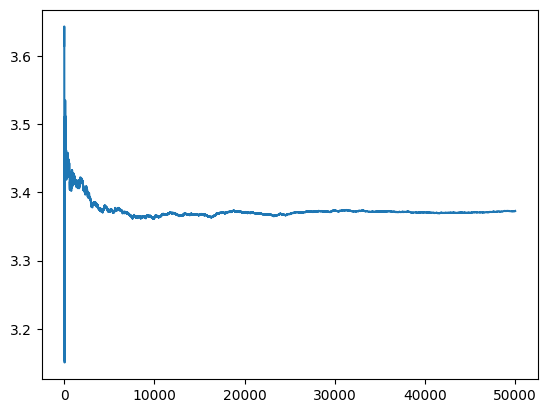

In [90]:
plt.plot(loom.tv.nll_list)

In [91]:
def pprint(mat):
    for row in range(mat.shape[0]):
        for col in range(mat.shape[1]):
            if col % 8 == 0 and col > 0:
                print('\n          ', end = '')
            print(f"{mat[row, col] : <.6f}".rjust(10, ' '), end = '')
        print()
print("LF_ON_OPERATORS")
pprint(loom.lf_on_operators)
print("START_STATE")
pprint(loom.start_state.T)
print("LF")
pprint(loom.lin_func)
np.sum(loom.lf_on_operators * loom.start_state)

LF_ON_OPERATORS
  0.050049 -0.021351  0.002231 -0.004406  0.007790
  1.380708 -0.613335  0.588475 -0.233146 -0.042791
  1.124178 -0.499197 -0.993348  0.381586 -0.018042
  0.865678 -0.384201  0.656318 -0.243269 -0.007366
  0.676327 -0.299069  0.971705 -0.377288  0.023069
  0.242590 -0.108514  0.661737 -0.258017 -0.011128
  0.770776 -0.341627  0.138192 -0.058814  0.030236
  1.447912 -0.641644 -1.255479  0.485135  0.026691
  0.548922 -0.245075 -0.424684  0.167267  0.017404
  0.477784 -0.213414  1.325061 -0.521796 -0.015523
  0.096624 -0.043068 -0.068864  0.026940  0.008369
  1.028050 -0.455915  0.090188 -0.045489  0.008738
  0.390847 -0.174107  0.392727 -0.158449  0.017066
  0.223658 -0.098998  0.575065 -0.222907  0.012146
  0.042069 -0.019232  0.086185 -0.033330  0.001266
START_STATE
  0.127921  0.052903  0.009316  0.003374  0.000026
LF
  9.366175 -4.158746  2.745507 -1.095984  0.057926


0.9999999999999999

In [66]:
mu = np.sum([op.mat for op in loom.operators], axis = 0)
mu_colsums = loom.lin_func * mu

pprint(mu)
print()
pprint(mu_colsums)
print()
pprint(loom.lin_func)
print()

colsums = np.sum(mu, axis = 1)
pprint(np.matrix(colsums))

    1.257156   -0.556148    0.530171   -0.192144    0.710949
    0.685164   -0.303244    0.295340   -0.105447    0.375050
    0.080040   -0.035778    0.086011   -0.026366    0.164290
    0.057314   -0.025674    0.061638   -0.019607    0.112382
    0.030376   -0.013403    0.096501   -0.031311   -0.077484

    8.330070   -3.685467    4.038235   -1.436768    4.679411

    8.330070   -3.685467    4.038235   -1.436768    4.679411

    1.749984    0.946863    0.268197    0.186054    0.004680


In [67]:
pprint(mu)

    1.257156   -0.556148    0.530171   -0.192144    0.710949
    0.685164   -0.303244    0.295340   -0.105447    0.375050
    0.080040   -0.035778    0.086011   -0.026366    0.164290
    0.057314   -0.025674    0.061638   -0.019607    0.112382
    0.030376   -0.013403    0.096501   -0.031311   -0.077484


In [68]:
for op in loom.operators:
    print(op.observable, end = ' ')
    pprint(loom.lin_func * op.mat)
    # print()

Oa     0.198492   -0.088793    0.036447   -0.015885    0.842679
Ob     0.150292   -0.066793   -0.008842    0.005652    0.124892
Oc     0.102955   -0.049447    0.365607   -0.120566    1.497479
Od     1.058047   -0.464867   -0.341820    0.096711   -0.342048
Oe     1.466671   -0.647690    0.875063   -0.295396   -0.315315
Of     1.457511   -0.637851   -0.523935    0.152216   -0.289577
Og     0.286069   -0.126218    0.831437   -0.276010   -0.132212
Oh     0.573623   -0.254793   -0.082410    0.012256    1.014652
Oi     0.076506   -0.035326    0.178197   -0.063212    0.794166
Oj     0.230411   -0.102915    0.090464   -0.030138    0.165408
Ok     1.046023   -0.460157   -0.391446    0.114330   -0.102027
Ol     0.605898   -0.267919   -0.003947   -0.015422    1.212387
Om     0.641789   -0.283376   -0.112447    0.031828    0.056345
On     0.182316   -0.083465    1.152186   -0.379959    0.330942
Oo     0.253466   -0.115857    1.973683   -0.653173   -0.178358
